# Logistic Regression Analysis of Sales Outcome

This notebook performs a logistic regression analysis to predict sales outcomes based on various variables extracted from sales transcripts. We'll follow a systematic workflow that includes data preparation, addressing multicollinearity, variable selection, model evaluation, and interpretation.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Data Preprocessing](#data-preprocessing)
5. [Initial Model Fitting](#initial-model-fitting)
6. [Multicollinearity Check](#multicollinearity-check)
7. [Variable Selection](#variable-selection)
8. [Model Evaluation](#model-evaluation)
9. [Model Interpretation](#model-interpretation)
10. [Conclusion](#conclusion)


In [1]:
! pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels > /dev/null 2>&1

The system cannot find the path specified.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import chi2_contingency
from scipy.stats import shapiro

# Modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
pd.set_option('display.max_columns', None)


<a id='introduction'></a>
## 1. Introduction

The goal of this analysis is to build a logistic regression model that predicts whether a sales outcome is a win or a loss based on various features extracted from sales call transcripts.

**Variables to be analyzed:**

- **Speech Features:**
  - `total_duration`, `ae_talk_ratio`, `no_talk_ratio_duration`, etc.
- **Question Metrics:**
  - `ae_total_questions`, `ae_question_ratio`, `client_total_questions`, etc.
- **Sentiment and Emotion Metrics:**
  - `sentiment_score`, `emotional_intensity_score`, `anger`, `joy`, etc.

We'll follow these steps:

1. Load and prepare the data.
2. Explore the data and perform initial analysis.
3. Preprocess the data (handle missing values, encode categorical variables, scale features).
4. Fit an initial logistic regression model with all variables.
5. Check for multicollinearity using Variance Inflation Factor (VIF).
6. Address multicollinearity by removing or combining variables or using regularization techniques.
7. Perform feature selection to identify the most significant predictors.
8. Evaluate the final model's performance.
9. Interpret the model coefficients and provide insights.


In [3]:
# For reproducibility
np.random.seed(42)

<a id='data-loading-and-preparation'></a>
## 2. Data Loading and Preparation

We'll start by loading the dataset from a CSV file and preparing it for analysis.


In [4]:
# Load the dataset
all_transcripts_df = pd.read_csv('transcript_dfs/all_transcripts_df.csv')

# Display the first few rows
all_transcripts_df.head()

,id,title,ae_name,ae_email,sales_outcome,date,meeting_attendees,host_email,transcript_url,video_url,audio_url,total_duration,ae_talk_duration,client_talk_duration,no_talk_duration,ae_talk_ratio,client_talk_ratio,ae_talk_ratio_duration,client_talk_ratio_duration,no_talk_ratio_duration,ae_total_questions,ae_question_ratio,ae_questions_per_minute,ae_first_question_timing_seconds,ae_entropy,ae_gini_coefficient,ae_ave_time_between_questions_seconds,ae_questions_per_segment,client_total_questions,client_question_ratio,client_questions_per_minute,client_first_question_timing_seconds,client_entropy,client_gini_coefficient,client_ave_time_between_questions_seconds,client_questions_per_segment,sentiment_score,emotional_intensity_score,anger,disgust,fear,joy,sadness,surprise,sentiment_balance_ratio,ae_sentiment,client_sentiment,ae_sentiment_variability,client_sentiment_variability,ae_sentiment_trend,client_sentiment_trend,emotional_reciprocity
0,FxuRiyttDW782zH3,Greg <> My Amazon Guy,Shawn Henderson,shawn.henderson@myamazonguy.com,closed_lost,2023/09/19,"sales@motomfg.com, shawn.henderson@myamazonguy...",albert.lapuz@myamazonguy.com,https://app.fireflies.ai/view/FxuRiyttDW782zH3,https://cdn.fireflies.ai/FxuRiyttDW782zH3/vide...,https://cdn.fireflies.ai/FxuRiyttDW782zH3/audi...,3684.41,2543.468,767.444,373.498,0.768208,0.231792,0.690333,0.208295,0.101373,54,0.79,0.88,13.16,0.917867,0.325926,69.15,"8, 1, 12, 1, 5, 5, 3, 6, 5, 8",12,0.21,0.20,15.32,0.878495,0.333333,324.40,"1, 1, 2, 0, 1, 2, 0, 2, 1, 2",0.127632,0.168270,0.019343,0.029039,0.008693,0.037537,0.018408,0.055250,0.955511,0.041697,0.009316,0.368851,0.414361,-0.000135,0.000305,0.088540
1,7k46Yz2dBBSlUTYB,Yasir <> My Amazon Guy,Matt Lopez,matt.lopez@myamazonguy.com,closed_lost,2023/09/14,"matt.lopez@myamazonguy.com, nina.villaruz@myam...",nina.villaruz@myamazonguy.com,https://app.fireflies.ai/view/7k46Yz2dBBSlUTYB,https://cdn.fireflies.ai/7k46Yz2dBBSlUTYB/vide...,https://cdn.fireflies.ai/7k46Yz2dBBSlUTYB/audi...,966.86,468.910,314.240,183.710,0.598749,0.401251,0.484982,0.325011,0.190007,12,0.71,0.74,39.51,0.859558,0.383333,82.78,"2, 1, 3, 0, 2, 0, 1, 1, 1, 1",5,0.29,0.31,0.70,0.578558,0.660000,170.92,"1, 0, 0, 2, 0, 1, 0, 1, 0, 0",0.037516,0.306367,0.027022,0.047566,0.031269,0.057778,0.070424,0.072306,0.643315,0.033193,0.016307,0.394851,0.368412,-0.000632,-0.000423,-0.047999
2,I7fHBY3mXdH0p1z6,"EPE INDUSTRIES USA, INC. - David <> My Amazon Guy",John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/21,"christene.mendoza@myamazonguy.com, john.aspina...",christene.mendoza@myamazonguy.com,https://app.fireflies.ai/view/I7fHBY3mXdH0p1z6,https://cdn.fireflies.ai/I7fHBY3mXdH0p1z6/vide...,https://cdn.fireflies.ai/I7fHBY3mXdH0p1z6/audi...,941.32,730.572,146.076,64.672,0.833370,0.166630,0.776114,0.155182,0.068704,29,0.97,1.85,2.83,0.881969,0.382759,30.77,"2, 2, 7, 6, 3, 4, 0, 2, 2, 1",3,0.03,0.19,5.88,0.477121,0.700000,405.13,"1, 0, 0, 0, 0, 1, 0, 0, 1, 0",0.013949,0.201851,0.032581,0.065411,0.007686,0.030010,0.017538,0.048625,0.564766,0.003723,0.047967,0.412839,0.294253,-0.000073,-0.000296,0.274073
3,ZFxjWW0HNgH9LwNW,Marieke <> My Amazon Guy,John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/21,"marieke@pinkgellac.com, john.aspinall@myamazon...",john.aspinall@myamazonguy.com,https://app.fireflies.ai/view/ZFxjWW0HNgH9LwNW,https://cdn.fireflies.ai/ZFxjWW0HNgH9LwNW/vide...,https://cdn.fireflies.ai/ZFxjWW0HNgH9LwNW/audi...,2007.57,1450.142,410.064,147.364,0.779560,0.220440,0.722337,0.204259,0.073404,60,0.89,1.79,47.30,0.934987,0.300000,32.29,"2, 10, 5, 11, 4, 11, 2, 6, 4, 5",15,0.11,0.45,148.74,0.864831,0.380000,115.58,"3, 2, 2, 1, 2, 1, 0, 3, 1, 0",0.023343,0.196026,0.028274,0.047890,0.009162,0.029954,0.018106,0.062640,0.504200,0.004530,0.024980,0.380418,0.445578,0.000042,0.000056,0.078420
4,jRxXxp3oAK2sJ4S9,Charles <> My Amazon Guy,John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/22,"charles@rushdirect.net, john.aspinall@myamazon...",john.aspinall@myamazon

**Note:** The dataset is assumed to be loaded successfully. The DataFrame `all_transcripts_df` contains all the necessary variables for analysis.


In [5]:
# Check the shape of the DataFrame
print(f"The dataset contains {all_transcripts_df.shape[0]} rows and {all_transcripts_df.shape[1]} columns.")

The dataset contains 1724 rows and 52 columns.


### Creating the Binary Outcome Variable

We need to create a binary variable `sales_outcome_binary` where:

- `1` represents a **won** sale.
- `0` represents a **lost** sale.


In [6]:
# Map 'sales_outcome' to binary values
all_transcripts_df['sales_outcome_binary'] = all_transcripts_df['sales_outcome'].map({
    'closed_won': 1,
    'closed_lost': 0
})

# Drop rows with missing sales outcome
all_transcripts_df.dropna(subset=['sales_outcome_binary'], inplace=True)

# Verify the mapping
all_transcripts_df['sales_outcome_binary'].value_counts()


0    1437
1     287
Name: sales_outcome_binary, dtype: int64

### Selecting the Variables for Analysis

We'll focus on the variables specified earlier.


In [7]:
# List of variables to analyze
variables = [
    'total_duration', 'ae_talk_ratio', 'no_talk_ratio_duration', 'ae_total_questions',
    'ae_question_ratio', 'ae_questions_per_minute', 'ae_first_question_timing_seconds',
    'ae_entropy', 'ae_gini_coefficient', 'ae_ave_time_between_questions_seconds',
    'client_total_questions', 'client_question_ratio',
    'client_questions_per_minute', 'client_first_question_timing_seconds', 'client_entropy',
    'client_gini_coefficient', 'client_ave_time_between_questions_seconds',
    'sentiment_score', 'emotional_intensity_score',
    'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'sentiment_balance_ratio',
    'ae_sentiment', 'client_sentiment', 'ae_sentiment_variability',
    'client_sentiment_variability', 'ae_sentiment_trend', 'client_sentiment_trend',
    'emotional_reciprocity'
]

# Ensure all variables are present in the DataFrame
variables = [var for var in variables if var in all_transcripts_df.columns]

print(f"Number of variables for analysis: {len(variables)}")


Number of variables for analysis: 33


<a id='exploratory-data-analysis'></a>
## 3. Exploratory Data Analysis

Before modeling, it's essential to understand the data distribution, identify missing values, and detect any anomalies.


In [8]:
# Summary statistics
all_transcripts_df[variables + ['sales_outcome_binary']].describe()


,total_duration,ae_talk_ratio,no_talk_ratio_duration,ae_total_questions,ae_question_ratio,ae_questions_per_minute,ae_first_question_timing_seconds,ae_entropy,ae_gini_coefficient,ae_ave_time_between_questions_seconds,client_total_questions,client_question_ratio,client_questions_per_minute,client_first_question_timing_seconds,client_entropy,client_gini_coefficient,client_ave_time_between_questions_seconds,sentiment_score,emotional_intensity_score,anger,disgust,fear,joy,sadness,surprise,sentiment_balance_ratio,ae_sentiment,client_sentiment,ae_sentiment_variability,client_sentiment_variability,ae_sentiment_trend,client_sentiment_trend,emotional_reciprocity,sales_outcome_binary
count,1724.000000,1724.000000,1724.000000,1724.000000,1621.000000,1724.000000,1568.000000,1568.000000,1568.000000,1545.000000,1724.00000,1621.000000,1724.000000,1529.000000,1529.000000,1529.000000,1479.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1722.000000,1724.000000
mean,1791.981682,0.603070,0.151300,25.801044,0.624109,0.862419,39.743253,0.788070,0.450218,79.772472,14.12007,0.375891,0.471038,144.143231,0.687840,0.541988,144.405139,0.076092,0.229041,0.030395,0.042407,0.013617,0.046918,0.025305,0.070398,1.306824,0.032648,0.040817,0.334401,0.355275,0.000173,-0.001025,0.102960,0.166473
std,1060.842529,0.249310,0.171363,19.731905,0.244194,0.595241,91.766436,0.191057,0.167988,59.449498,12.92238,0.244194,0.405177,252.392717,0.219341,0.168599,112.559553,0.106908,0.091139,0.032331,0.024110,0.027360,0.039623,0.022986,0.039592,3.072726,0.029184,0.243911,0.108563,0.131823,0.042190,0.024350,0.122685,0.372613
min,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087879,1.870000,0.00000,0.000000,0.000000,0.000000,0.000000,0.103226,2.010000,-0.782140,0.031219,0.002899,0.002009,0.001183,0.002275,0.003894,0.002911,-17.504390,-0.158649,-0.792439,0.000000,0.000000,-0.647468,-0.677559,-0.998520,0.000000
25%,1016.950000,0.517277,0.078926,10.000000,0.470000,0.480000,0.567500,0.727942,0.326667,45.380000,5.00000,0.190000,0.220000,3.180000,0.587072,0.412500,79.530000,0.026568,0.180004,0.020724,0.028024,0.007484,0.031252,0.016388,0.055750,0.641756,0.016582,0.003438,0.319022,0.331501,-0.000181,0.000000,0.002703,0.000000
50%,1737.139000,0.652305,0.101937,23.000000,0.650000,0.810000,4.660000,0.849561,0.421212,64.200000,11.00000,0.350000,0.400000,31.540000,0.747071,0.530769,117.670000,0.080701,0.216226,0.026353,0.037923,0.010154,0.042301,0.020394,0.066041,0.853590,0.031771,0.020208,0.364515,0.391011,0.000000,0.000171,0.094712,0.000000
75%,2521.854500,0.755577,0.138154,37.000000,0.810000,1.150000,29.217500,0.914626,0.554545,94.180000,20.00000,0.530000,0.620000,178.990000,0.844442,0.660000,177.620000,0.127457,0.253247,0.033175,0.050761,0.014306,0.053954,0.027031,0.077933,1.075475,0.045871,0.039619,0.392735,0.432129,0.000186,0.000569,0.175804,0.000000
max,7206.670000,1.000000,0.997141,117.000000,1.000000,7.910000,1182.240000,0.994034,0.900000,907.340000,131.00000,1.000000,4.060000,2041.860000,0.992017,0.900000,1886.980000,0.953028,0.987346,0.829375,0.319499,0.773737,0.813123,0.325010,0.870939,18.890684,0.491005,6.274217,0.661659,0.588827,1.458988,0.190267,0.672020,1.000000


In [9]:
# Check for missing values
missing_values = all_transcripts_df[variables].isnull().sum().sort_values(ascending=False)
print("Missing values in each variable:")
print(missing_values[missing_values > 0])


Missing values in each variable:
client_ave_time_between_questions_seconds    245
client_gini_coefficient                      195
client_entropy                               195
client_first_question_timing_seconds         195
ae_ave_time_between_questions_seconds        179
ae_first_question_timing_seconds             156
ae_entropy                                   156
ae_gini_coefficient                          156
client_question_ratio                        103
ae_question_ratio                            103
emotional_reciprocity                          2
dtype: int64


### Handling Missing Values

We'll need to handle missing values appropriately. Common strategies include:

- **Dropping missing values:** If the number of missing values is small.
- **Imputation:** Filling missing values with mean, median, or using more advanced techniques.

For simplicity, we'll proceed by dropping rows with missing values in the selected variables.


In [10]:
# Drop rows with missing values in the selected variables
all_transcripts_df.dropna(subset=variables, inplace=True)

# Verify that there are no missing values
print("Missing values after dropping:")
print(all_transcripts_df[variables].isnull().sum().sum())


Missing values after dropping:
0


### Handling Mishandled Transcripts

We'll also check for any transcripts that were mishandled during data collection and remove them from the analysis.

Theses transcripts can be identified by checking the `ae_talk_ratio`. If the ratio is `0` or `1`, it indicates that the speakers were not correctly identified.

In [11]:
# Identify mishandled transcripts
mishandled_transcripts = all_transcripts_df[
    (all_transcripts_df['ae_talk_ratio'] == 0) | (all_transcripts_df['ae_talk_ratio'] == 1)
]

print(f"Number of mishandled transcripts: {len(mishandled_transcripts)}")

# Remove mishandled transcripts from the dataset
all_transcripts_df = all_transcripts_df[
    (all_transcripts_df['ae_talk_ratio'] != 0) & (all_transcripts_df['ae_talk_ratio'] != 1)
]

print(f"Number of transcripts after removing mishandled ones: {len(all_transcripts_df)}")


Number of mishandled transcripts: 37
Number of transcripts after removing mishandled ones: 1397


<a id='data-preprocessing'></a>
## 4. Data Preprocessing

### Splitting the Data

We'll split the data into features (`X`) and target (`y`).


In [12]:
# Features and target
X = all_transcripts_df[variables]
y = all_transcripts_df['sales_outcome_binary']


### Standardizing the Features

Logistic regression can benefit from feature scaling, especially when regularization is used.


In [13]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled = pd.DataFrame(X_scaled, columns=variables)


### Splitting into Training and Test Sets

We'll split the data into training and test sets to evaluate the model's performance on unseen data.


In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 1117 samples
Test set size: 280 samples


<a id='initial-model-fitting'></a>
## 5. Initial Model Fitting

We'll fit an initial logistic regression model using all variables.


In [15]:
# Initialize the logistic regression model
log_reg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)

# Fit the model on the training data
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, penalty='none')

**Note:** We've set `penalty='none'` to fit a model without regularization initially.

<a id='multicollinearity-check'></a>
## 6. Multicollinearity Check

Multicollinearity can inflate the variance of coefficient estimates and make the model unstable. We'll calculate the Variance Inflation Factor (VIF) for each feature.


In [16]:
# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data

# Calculate VIF on the training set
vif_df = calculate_vif(X_train)

print("Variance Inflation Factor (VIF) for each feature:")
vif_df.sort_values('VIF', ascending=False)


Variance Inflation Factor (VIF) for each feature:


,Feature,VIF
4,ae_question_ratio,inf
11,client_question_ratio,inf
18,emotional_intensity_score,1.429714e+14
22,joy,1.597021e+13
20,disgust,1.585775e+13
24,surprise,1.547629e+13
19,anger,1.003029e+13
23,sadness,5.875538e+12
21,fear,1.948345e+12
14,client_entropy,1.920663e+01


### Addressing Multicollinearity

Variables with VIF values greater than 5 indicate potential multicollinearity issues. We'll consider removing or combining these variables.

#### **Option 1: Remove Variables with High VIF**

We'll remove variables with VIF > 5 and refit the model.


In [17]:
# Identify variables with VIF > 5
high_vif_features = vif_df[vif_df['VIF'] > 5]['Feature']
print("Features with VIF > 5:")
print(high_vif_features.tolist())


Features with VIF > 5:
['total_duration', 'ae_total_questions', 'ae_question_ratio', 'ae_questions_per_minute', 'ae_entropy', 'ae_gini_coefficient', 'client_total_questions', 'client_question_ratio', 'client_questions_per_minute', 'client_entropy', 'client_gini_coefficient', 'sentiment_score', 'emotional_intensity_score', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'sentiment_balance_ratio']


In [18]:
# Remove high VIF features
X_train_reduced = X_train.drop(columns=high_vif_features)
X_test_reduced = X_test.drop(columns=high_vif_features)

# Recalculate VIF after removal
vif_df_reduced = calculate_vif(X_train_reduced)
print("VIF after removing high VIF features:")
vif_df_reduced.sort_values('VIF', ascending=False)


VIF after removing high VIF features:


,Feature,VIF
0,ae_talk_ratio,1.475475
6,ae_sentiment,1.238393
9,client_sentiment_variability,1.228120
7,client_sentiment,1.219827
1,no_talk_ratio_duration,1.192278
8,ae_sentiment_variability,1.150076
2,ae_first_question_timing_seconds,1.150055
11,client_sentiment_trend,1.137856
3,ae_ave_time_between_questions_seconds,1.124767
4,client_first_question_timing_seconds,1.123521


<a id='variable-selection'></a>
## 7. Variable Selection

To further refine the model, we'll perform feature selection using Recursive Feature Elimination with Cross-Validation (RFECV).

### Recursive Feature Elimination with Cross-Validation (RFECV)


In [ ]:
# Initialize logistic regression with L1 penalty
log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Fit the model
log_reg_lasso.fit(X_train_reduced, y_train)

# Get the coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Coefficient': log_reg_lasso.coef_[0]
})

# Identify selected features
selected_features_lasso = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]['Feature'].tolist()
print("Selected features using Lasso:", selected_features_lasso)


In [32]:
from sklearn.feature_selection import RFECV

# Initialize the logistic regression model with regularization
log_reg_rfe = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Initialize RFECV with a smaller step size
rfecv = RFECV(
    estimator=log_reg_rfe,
    step=1,
    cv=10,  # Increase from 5 to 10 folds
    scoring='accuracy',
    n_jobs=-1
)


# Fit RFECV on the reduced training data
rfecv.fit(X_train_reduced, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")


Optimal number of features: 1


In [20]:
# Selected features
selected_features = X_train_reduced.columns[rfecv.support_].tolist()
print("Selected features after RFECV:")
print(selected_features)


Selected features after RFECV:
['ae_sentiment_trend']


### Fitting the Final Model

We'll fit the logistic regression model using only the selected features.


In [21]:
# Subset the training and test sets
X_train_final = X_train_reduced[selected_features]
X_test_final = X_test_reduced[selected_features]

# Initialize the logistic regression model with regularization
final_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit the final model
final_model.fit(X_train_final, y_train)


LogisticRegression(max_iter=1000)

<a id='model-evaluation'></a>
## 8. Model Evaluation

We'll evaluate the model's performance on the test set.


In [22]:
# Predict on the test set
y_pred = final_model.predict(X_test_final)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")


Test set accuracy: 0.8250


In [23]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       231
           1       0.00      0.00      0.00        49

    accuracy                           0.82       280
   macro avg       0.41      0.50      0.45       280
weighted avg       0.68      0.82      0.75       280



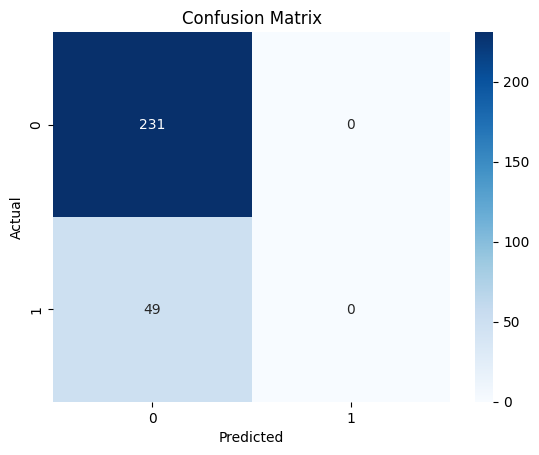

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ROC AUC Score: 0.4958


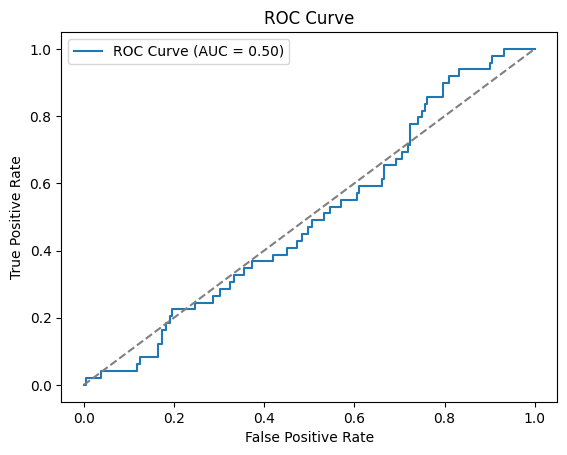

In [25]:
# ROC Curve and AUC
y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


<a id='model-interpretation'></a>
## 9. Model Interpretation

### Coefficient Analysis

We'll examine the coefficients of the final model to understand the impact of each feature.


In [26]:
# Recalculate VIFs for all features in the initial model
vif_df_initial = calculate_vif(X_train)

# Create a DataFrame for coefficients of the final model
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_model.coef_[0]
})

# Calculate odds ratios for included features
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])

# Add a column to indicate that these features were included
coefficients['Included in Final Model'] = 'Yes'

# For features that were dropped, set coefficients and odds ratios to NaN
dropped_features = [feature for feature in X_train.columns if feature not in selected_features]

# Create a DataFrame for dropped features
dropped_df = pd.DataFrame({
    'Feature': dropped_features,
    'Coefficient': [np.nan]*len(dropped_features),
    'Odds Ratio': [np.nan]*len(dropped_features),
    'Included in Final Model': 'No'
})

# Combine the coefficients of included and dropped features
all_features_df = pd.concat([coefficients, dropped_df], ignore_index=True)

# Merge with VIF values
# Rename VIF column for clarity
vif_df_initial.rename(columns={'VIF': 'VIF Score'}, inplace=True)

# Merge VIFs with all_features_df
all_features_df = all_features_df.merge(vif_df_initial[['Feature', 'VIF Score']], on='Feature', how='left')

# Sort the DataFrame for better readability
all_features_df.sort_values(by='Included in Final Model', ascending=False, inplace=True)

# Reset index
all_features_df.reset_index(drop=True, inplace=True)

# Display the final table
all_features_df[['Feature', 'Included in Final Model', 'Coefficient', 'Odds Ratio', 'VIF Score']]


,Feature,Included in Final Model,Coefficient,Odds Ratio,VIF Score
0,ae_sentiment_trend,Yes,0.230072,1.258691,1.305228e+00
1,client_ave_time_between_questions_seconds,No,NaN,NaN,1.966506e+00
2,client_sentiment_trend,No,NaN,NaN,1.944956e+00
3,client_sentiment_variability,No,NaN,NaN,1.617620e+00
4,ae_sentiment_variability,No,NaN,NaN,1.894779e+00
5,client_sentiment,No,NaN,NaN,2.604905e+00
6,ae_sentiment,No,NaN,NaN,3.191576e+00
7,sentiment_balance_ratio,No,NaN,NaN,5.656808e+00
8,surprise,No,NaN,NaN,1.547629e+13
9,sadness,No,NaN,NaN,5.875538e+12


### Coefficient Table with All Features

The table below includes all the features from the initial model, indicating whether they were included in the final model. Coefficients and odds ratios are shown for the features included in the final model. For dropped features, these values are marked as N/A. The VIF scores are provided for all features.

**Table: Coefficients, Odds Ratios, and VIF Scores**



In [27]:
# Display the table
display(all_features_df[['Feature', 'Included in Final Model', 'Coefficient', 'Odds Ratio', 'VIF Score']])


,Feature,Included in Final Model,Coefficient,Odds Ratio,VIF Score
0,ae_sentiment_trend,Yes,0.230072,1.258691,1.305228e+00
1,client_ave_time_between_questions_seconds,No,NaN,NaN,1.966506e+00
2,client_sentiment_trend,No,NaN,NaN,1.944956e+00
3,client_sentiment_variability,No,NaN,NaN,1.617620e+00
4,ae_sentiment_variability,No,NaN,NaN,1.894779e+00
5,client_sentiment,No,NaN,NaN,2.604905e+00
6,ae_sentiment,No,NaN,NaN,3.191576e+00
7,sentiment_balance_ratio,No,NaN,NaN,5.656808e+00
8,surprise,No,NaN,NaN,1.547629e+13
9,sadness,No,NaN,NaN,5.875538e+12


### Interpretation

- **Included Features:** These features have coefficients and odds ratios calculated from the final model. The coefficient represents the change in the log-odds of the sales being won for a one-unit increase in the feature, holding all other variables constant. The odds ratio is the exponentiation of the coefficient, indicating how the odds change with a one-unit increase in the feature.

- **Dropped Features:** These features were not included in the final model after feature selection, possibly due to high multicollinearity (indicated by high VIF scores) or low importance. Their coefficients and odds ratios are marked as N/A.

- **VIF Scores:** The Variance Inflation Factor (VIF) scores provide insight into multicollinearity among the features. A VIF score greater than 5 suggests significant multicollinearity, which can inflate the variance of coefficient estimates and make them unstable.

#### Example Interpretation of Included Features:

- **Feature with Positive Coefficient:**
  - If a feature like `ae_questions_per_minute` has a positive coefficient and is included in the final model, it suggests that as the account executive (AE) asks more questions per minute, the likelihood of winning the sale increases.

- **Feature with Negative Coefficient:**
  - If a feature like `client_first_question_timing_seconds` has a negative coefficient, it indicates that a longer time before the client asks their first question is associated with a decreased likelihood of winning the sale.

#### Example Interpretation of Dropped Features:

- **Feature with High VIF Score:**
  - A feature like `ae_total_questions` might have a high VIF score and was dropped from the final model. This suggests it was highly correlated with other variables, and its inclusion could have caused multicollinearity issues.

### Considerations:

- **Multicollinearity Impact:**
  - High VIF scores among dropped features indicate multicollinearity, which can distort the model's estimates and reduce interpretability.

- **Importance of Feature Selection:**
  - Including only the most significant and independent features improves the model's performance and generalizability.

- **Further Analysis:**
  - For dropped features with low VIF scores, consider investigating why they were not selected—perhaps they have low predictive power or are redundant given the other included features.

### Visualizing Coefficients

For better visualization, we can plot the coefficients and their confidence intervals (if computed) for the included features.


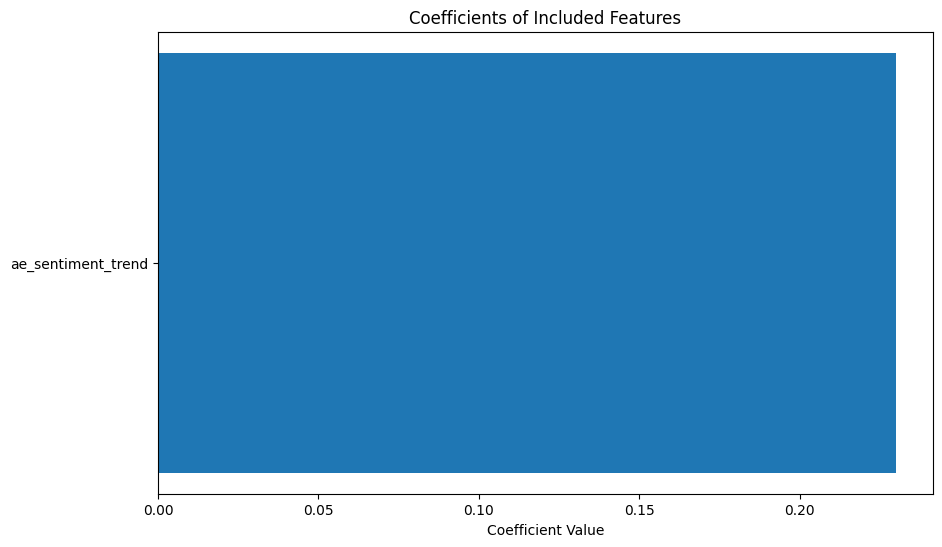

In [28]:
# Plotting the coefficients of included features
import matplotlib.pyplot as plt

# Filter only included features
included_features_df = all_features_df[all_features_df['Included in Final Model'] == 'Yes']

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(included_features_df['Feature'], included_features_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Coefficients of Included Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top
plt.show()


### Notes:

- **Coefficients Interpretation:**
  - **Positive Coefficient:** Increases the log-odds of winning the sale.
  - **Negative Coefficient:** Decreases the log-odds of winning the sale.

- **Scaling Impact:**
  - Since we standardized the features, the coefficients represent the effect of a one standard deviation increase in the feature.

- **Business Context:**
  - It's important to interpret the results in the context of sales interactions. Features related to engagement, questioning strategies, and emotional content can provide actionable insights.

### Additional Information:

- **Standard Errors and p-values:**
  - For a detailed statistical interpretation, we can extract standard errors, z-scores, and p-values using `statsmodels`. This can help in assessing the significance of each coefficient.

#### Using `statsmodels` for Detailed Summary:



In [29]:
# Fit the model using statsmodels for detailed summary
import statsmodels.api as sm

# Option 1: Reset the indices
X_train_final_reset = X_train_final.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Add a constant term for intercept
X_train_final_sm = sm.add_constant(X_train_final_reset)

# Fit the model
logit_model = sm.Logit(y_train_reset, X_train_final_sm)
result = logit_model.fit()

# Display the summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.458681
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     sales_outcome_binary   No. Observations:                 1117
Model:                            Logit   Df Residuals:                     1115
Method:                             MLE   Df Model:                            1
Date:                  Fri, 25 Oct 2024   Pseudo R-squ.:                0.006480
Time:                          16:52:32   Log-Likelihood:                -512.35
converged:                         True   LL-Null:                       -515.69
Covariance Type:              nonrobust   LLR p-value:                  0.009734
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5760      0.080    -19.694      0.000      -1.733  

**Interpretation:**

- **P>|z| (p-value):**
  - Indicates the significance of each coefficient. A p-value less than 0.05 suggests the coefficient is statistically significant.

- **[0.025  0.975] (Confidence Interval):**
  - The 95% confidence interval for each coefficient.

**Note:** The summary provides a comprehensive statistical analysis, which can be valuable for understanding the reliability of the model and each predictor.


<a id='conclusion'></a>
## 10. Conclusion

TBA
